In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from lxml.builder import E
from lxml.etree import tostring

In [2]:
df = pd.read_csv('fw-matches-1.csv')

In [3]:
df.iloc[0]['Text B']

'/home/jon/Code/corpus-joyce-finnegans-wake-tei/criticism-analysis/1/ocr/journal-article-10.2307_25473839.txt'

In [4]:
df.iloc[0]

Text A            /home/jon/Code/corpus-joyce-finnegans-wake-tei...
Text B            /home/jon/Code/corpus-joyce-finnegans-wake-tei...
Threshold                                                         3
Cutoff                                                            5
N-Grams                                                           3
Num Matches                                                       1
Text A Length                                               2637332
Text B Length                                                 45234
Locations in A                                 [(1220539, 1220594)]
Locations in B                                       [(5567, 5622)]
Name: 0, dtype: object

# What parts of Finnegans Wake tend to be quoted? 

In [5]:
wakeFn = df.iloc[0]['Text A']

In [6]:
wake = open(wakeFn).read()

In [7]:
wake[:200]

'<?xml version="1.0" encoding="UTF-8"?>\n<TEI>\n   <teiHeader>\n      <fileDesc/>\n      <encodingDesc>\n         <charDecl>\n            <glyph xml:id="ALP">\n               <mapping type="font" rendition="#'

In [8]:
len(wake)

2637480

In [9]:
# Bin locations in A

In [10]:
bins = pd.cut(range(len(wake)), 10)

In [11]:
allLocations = []
for row in df['Locations in A']: 
    for item in eval(row): 
        allLocations.append(item[0])

In [12]:
counts, bins = np.histogram(allLocations, bins=50)

# Number of quotations according to their position in the novel. Chunks of 50. 

<AxesSubplot:>

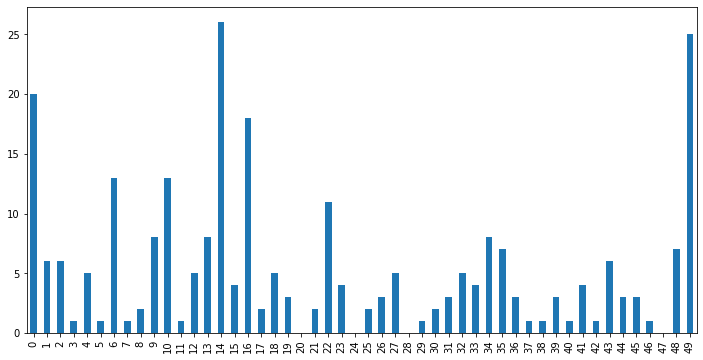

In [13]:
pd.Series(counts).plot(kind='bar', figsize=(12, 6))

In [14]:
bins[14]

743809.7200000001

[loc for loc in allLocations if loc > 730000 and loc < 760000]

## A frequently quoted passage (the most frequently quoted?)

In [15]:
print(wake[746575:749269]) 

dictas, visus umbique, ahems and ahahs, imeffible tries at</l>
                  <l xml:id="L1.7.183.15">speech unasyllabled, you owe mes, eyoldhyms, fluefoul smut,</l>
                  <l xml:id="L1.7.183.16">fallen lucifers, vestas which had served, showered ornaments,</l>
                  <l xml:id="L1.7.183.17">borrowed brogues, reversibles jackets, blackeye lenses, family</l>
                  <l xml:id="L1.7.183.18">jars, falsehair shirts, Godforsaken scapulars, neverworn breeches,</l>
                  <l xml:id="L1.7.183.19">cutthroat ties, counterfeit franks, best intentions, curried notes,</l>
                  <l xml:id="L1.7.183.20">upset latten tintacks, unused mill and stumpling stones, twisted</l>
                  <l xml:id="L1.7.183.21">quills, painful digests, magnifying wineglasses, solid objects cast</l>
                  <l xml:id="L1.7.183.22">at goblins, once current puns, quashed quotatoes, messes of mot-</l>
                  <lb break="no"/>
                

It'd be interesting to compare densities of misspelled words (as detected by `aspell` or equivalent) with incidence of quotations.  

But anyway...

# Get some article metadata first

In [16]:
metadataMap = [('title', 'front//article-title')
                       , ('authorLast', 'front//contrib/string-name/surname')
                       , ('authorFirst', 'front//contrib/string-name/given-names')
                       , ('journal', 'front//journal-title')
                       , ('id', 'front//article-id')
                       , ('pubYear', 'front/article-meta/pub-date/year')
                       , ('pubMonth', 'front/article-meta/pub-date/month')
                       , ('pubDay', 'front/article-meta/pub-date/day')]

def getMeta(textBFilename): 
    xmlFilename = textBFilename.replace('/ocr/', '/metadata/').replace('.txt', '.xml')
    xmlRoot = ET.parse(open(xmlFilename)).getroot()
    metadata = {}
    for label, path in metadataMap:
        try: 
            datum = xmlRoot.find(path).text
        except: 
            datum = ""
        metadata[label] = datum
    return metadata

In [17]:
df['meta'] = df['Text B'].apply(getMeta)

In [18]:
for label in [pair[0] for pair in metadataMap]:
    df[label] = df['meta'].apply(lambda x: x[label])

In [19]:
list(xmlarticle.find('front/article-meta/pub-date'))

NameError: name 'xmlarticle' is not defined

# Most frequent authors of quoting articles

In [20]:
df['authorLast'].value_counts()

Benstock    9
Norris      5
            3
Morse       3
Beckman     3
           ..
KITCHER     1
Henke       1
Eide        1
Peery       1
Sabatini    1
Name: authorLast, Length: 152, dtype: int64

# Most frequent journals of quoting articles

In [21]:
df['journal'].value_counts().head(10)

James Joyce Quarterly              59
European Joyce Studies             23
Joyce Studies Annual               21
Journal of Modern Literature        8
ELH                                 5
Modern Fiction Studies              5
PMLA                                4
James Joyce Literary Supplement     4
Irish University Review             3
James Joyce Broadsheet              3
Name: journal, dtype: int64

In [22]:
tostring(E.foo(E.bar('hello')))

b'<foo><bar>hello</bar></foo>'

# Publication date ranges

<AxesSubplot:>

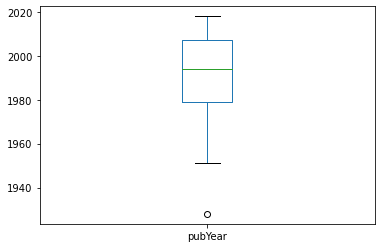

In [23]:
df['pubYear'].apply(lambda x: int(x) if x !='' else np.NaN).plot(kind='box')

<AxesSubplot:>

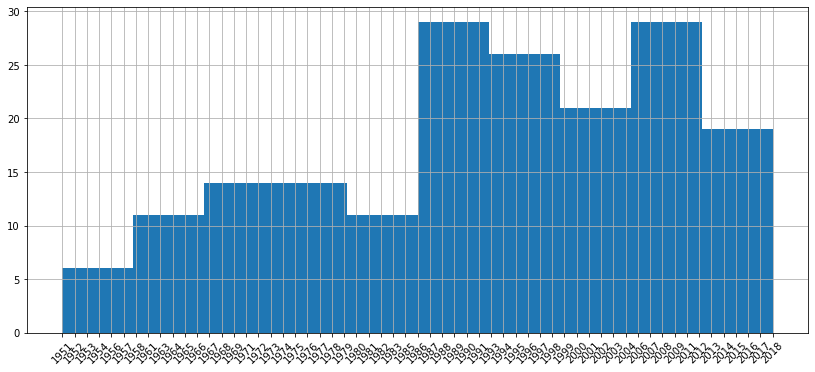

In [43]:
df['pubYear'][df['pubYear'] > '1930'].sort_values().hist(figsize=(14,6), xrot=45)

## Let's export these text matches to TEI

Use this structure: 

```xml
<?xml version="1.0" encoding="utf-8"?>
<standOff type="textMatching">

  <listBibl>
    <biblStruct xml:id="id-in-criticism">
      <!-- bibliographic stuff here -->
    </biblStruct>
  </listBibl>

  <linkGrp>
    <!-- for each match -->
    <link target="string-range(#id-in-FW, start, end) string-range(#id-in-criticism, start, end)" />
    <!-- end for -->
    </linkGrp>
</standOff>
```

In [177]:
tostring(E.standOff(E.listBibl(bibls), E.linkGrp(links), type='textMatching'))

b'<standOff type="textMatching"><listBibl>heyo</listBibl></standOff>'

In [184]:
df.iloc[0]['Locations in A']

'[(1220539, 1220594)]'

In [255]:
def makeLinks(row): 
    aLocs = eval(row['Locations in A'])
    bLocs = eval(row['Locations in B'])
    for locsA, locsB in zip(aLocs, bLocs):
        startA, endA = locsA
        startB, endB = locsB
        jstorId = row['id']
        yield E.link(target=f'string-range(#FW, {startA}, {endA}) string-range(#jstor{jstorId}, {startB}, {endB})')

In [288]:
allLinks = []
for i, row in df.iterrows(): 
    links = makeLinks(row)
    for link in links: 
        allLinks.append(link)

In [305]:
linkGrp = E.linkGrp(*allLinks)

In [385]:
def makeBibl(row, jstor=True): 
    jstorId = row.get('id')
    date = row['pubYear'] + '-' + row['pubMonth'] + '-' + row['pubDay']
    title = row.get('title', '')
    authorLast = row.get('authorLast', '')
    authorFirst = row.get('authorFirst', '')
    journal = row.get('journal', '')
    authorElem = E.author(E.persName(E.surname(authorLast), E.forename(authorFirst)))
    dateElem = E.date(when=date)
    if title is not None: 
        titleElem = E.title(title)
    else: 
        titleElem = E.title('')
    bibl = E.bibl(E.analytic(titleElem, authorElem), E.monog(E.title(journal), dateElem), type='article')
    if jstor: 
        bibl.attrib['id'] = '#jstor'+jstorId
    else: 
        bibl.attrib['id'] = row['id']
    return bibl

In [386]:
tostring(makeBibl(df.iloc[75]))

b'<bibl type="article" id="#jstor10.2307/461804"><analytic><title>Originality and Repetition in Finnegans Wake and Ulysses</title><author><persName><surname>Levine</surname><forename>Jennifer Schiffer</forename></persName></author></analytic><monog><title>PMLA</title><date when="1979-1-1"/></monog></bibl>'

In [387]:
df.iloc[0]

Text A            /home/jon/Code/corpus-joyce-finnegans-wake-tei...
Text B            /home/jon/Code/corpus-joyce-finnegans-wake-tei...
Threshold                                                         3
Cutoff                                                            5
N-Grams                                                           3
Num Matches                                                       1
Text A Length                                               2637332
Text B Length                                                 45234
Locations in A                                 [(1220539, 1220594)]
Locations in B                                       [(5567, 5622)]
meta              {'title': 'The Language of Flows: Fluidity, Vi...
title             The Language of Flows: Fluidity, Virology, and...
authorLast                                                     Eide
authorFirst                                                  Marian
journal                                       Ja

In [388]:
fwBibl = makeBibl({'title': "Finnegans Wake", "authorLast": "Joyce", "authorFirst": "James",
                  'pubYear': '1939', 'pubMonth': '5', 'pubDay': '4', 'id': '#FW'}, jstor=False)

In [389]:
tostring(fwBibl)

b'<bibl type="article" id="#FW"><analytic><title>Finnegans Wake</title><author><persName><surname>Joyce</surname><forename>James</forename></persName></author></analytic><monog><title></title><date when="1939-5-4"/></monog></bibl>'

In [390]:
bibls = []
for i, row in df.iterrows():
    bibls.append(makeBibl(row))
bibls = [fwBibl] + bibls

In [391]:
listBibls = E.listBibl(*bibls)

In [392]:
standoff = E.standOff(listBibls, linkGrp, type='textMatching')

In [393]:
bytesOut = tostring(standoff, encoding='utf8', pretty_print=True, xml_declaration=True)

In [394]:
open('matches.tei.xml', 'wb').write(bytesOut)

105872